# bear detector - data cleaning

## 安裝

In [ ]:
!pip install -Uqq fastai fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.8 MB/s eta 0:00:00


## 下載圖

"灰熊" 的圖：

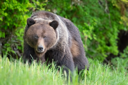

In [ ]:
from fastbook import *

dest = 'images/grizzly.jpg'
download_url(search_images_ddg('grizzly bear', max_images=1)[0], dest, show_progress=False)
Image.open(dest).to_thumb(128,128)

取得多張圖片，分別存在不同的目錄 (目錄名稱為 label)

In [ ]:
from time import sleep

searches = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
  for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} bear'))
    sleep(10)

下載壞的圖會造成訓練失敗，要移除掉

In [ ]:
failed = verify_images(get_image_files(path))
len(failed.map(Path.unlink))

21

## 圖像 resize

crop 效果

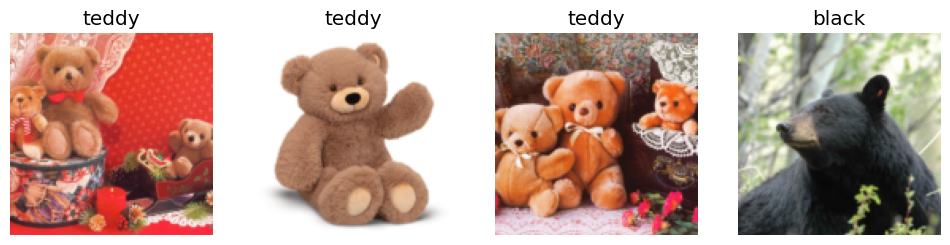

In [ ]:
bears = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=Resize(128)) # 預設為 Crop
dls = bears.dataloaders(path)

dls.valid.show_batch(max_n=4, nrows=1)

squish 效果

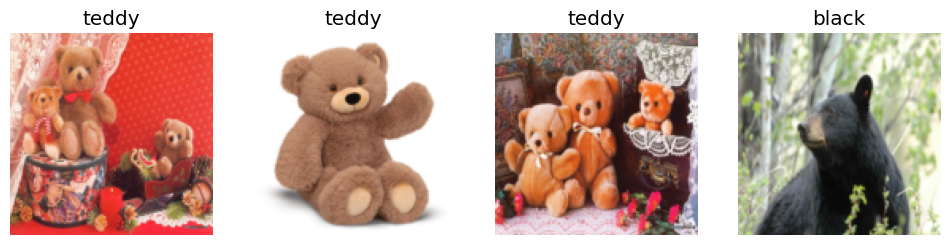

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

pad 效果

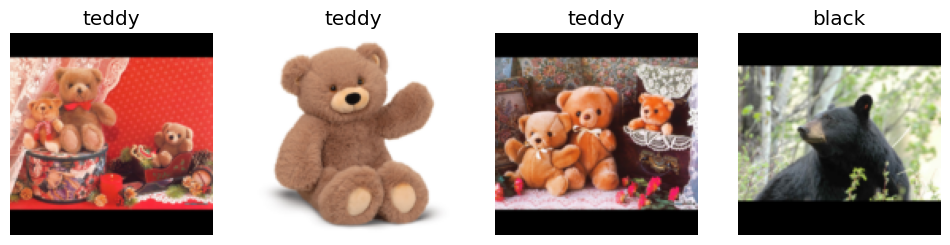

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

## data augmentation

`RandomResizedCrop`：抓取圖像的不同部分；這種每次從同一張圖像中獲取不同圖片的想法稱為 data augmentation；適用於運行很多次 epoch 時，每次都會得到略有不同的圖片
- min_scale：決定每次最少選擇多少圖像

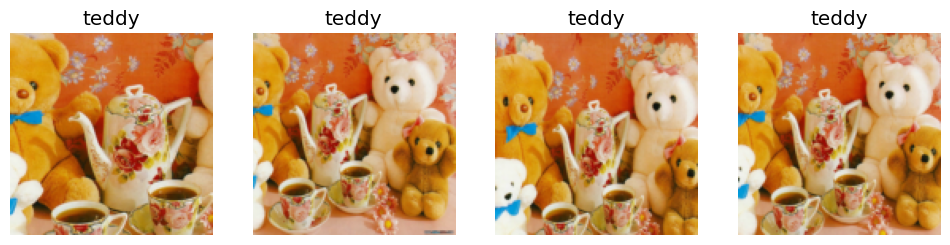

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True) # unique=True: 使用同一圖像, 套用 RandomResizedCrop 變換的不同版本

`aug_transforms`：數據增強，對圖片做旋轉、翻轉、透視扭曲、亮度變化、對比度變化等轉換
- mult：增強量

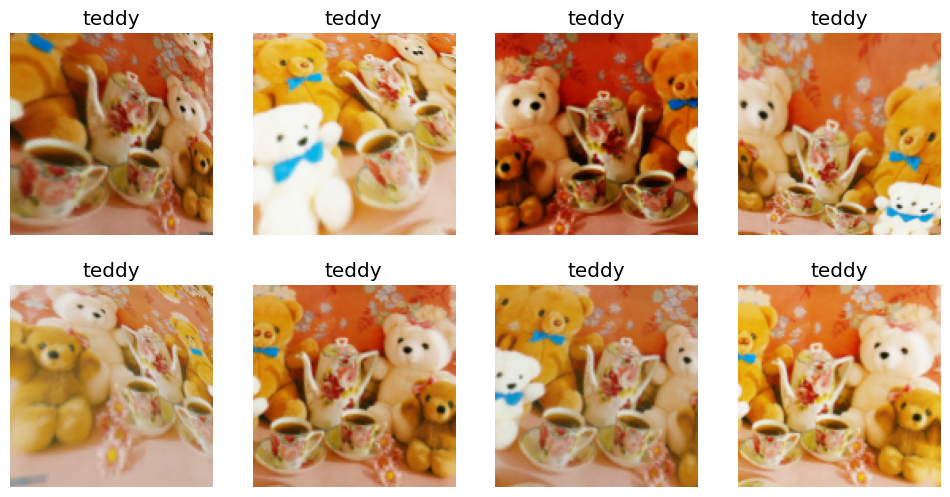

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## 訓練

In [ ]:
bears = bears.new(
  item_tfms=RandomResizedCrop(224, min_scale=0.5),
  batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


## 分析

confusion matrix：分析分類問題的錯誤情況

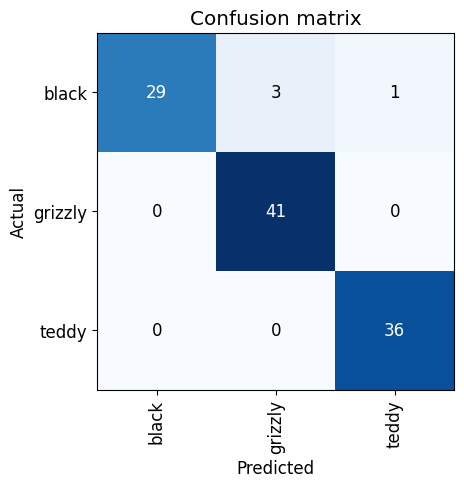

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

`plot_top_losses`：展示數據集中造損失值排序的圖像；如果模型不正確 (特別是如果它也對其錯誤答案充滿信心)，或者如果模型是正確的但對其正確答案沒有信心，則損失值會比較高

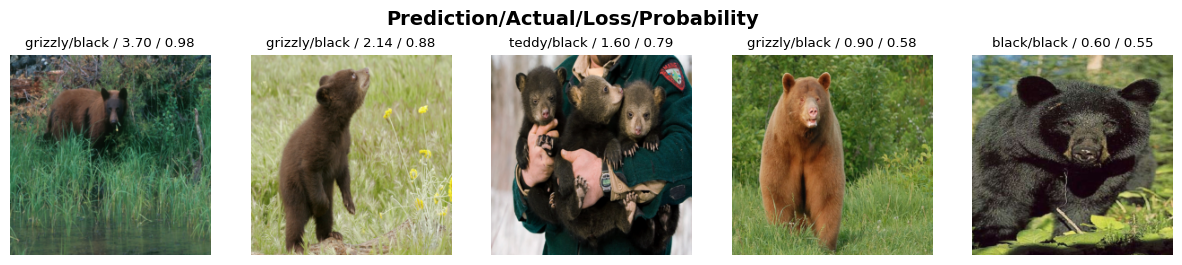

In [ ]:
plt.rcParams.update({'font.size': 8})
interp.plot_top_losses(5, nrows=1)

## data cleaning

`ImageClassifierCleaner`：GUI，用於 data cleaning，供選擇類別、訓練集、驗證集以查看造損失值排序的圖像，及允許選擇圖像進行刪除、重新標記

In [ ]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# 在線應用程式工具流

`Gradio`：為 ML 模型輕鬆生成創建交互式 web 應用

`HuggingFace`：託管 ML demo 應用服務，要當 AI 界的 Github

- `HuggingFace` 建立 space
  - `Space name`: minima
  - `License`: apache-2.0
  - `Select the Space SDK`: Gradio
  - 選擇 `Public`
- 建立 Gradio app.py 與相關程式碼
  - 若使用到 fastai，要在專案內新增 requirements.txt 告知要安裝的 module，含有以下文字內容
  ```
  fastai
  ```
- commit、push，`HuggingFace` 即開始建構你的應用
- 應用下方有連結 `Use via API`，提供應用的 API endpoint，可以用你喜歡的技術開發 client

[hello world](https://huggingface.co/spaces/spencer23/minima)

[dog vs. cat classifier](https://huggingface.co/spaces/spencer23/testing)



# dog vs. cat classifier - training

通常訓練時才需要 GPU

## 安裝

In [ ]:
!pip install -Uqq fastai

## 下載寵物的圖

In [ ]:
from fastai.vision.all import *

path = untar_data(URLs.PETS)/'images'

## 訓練

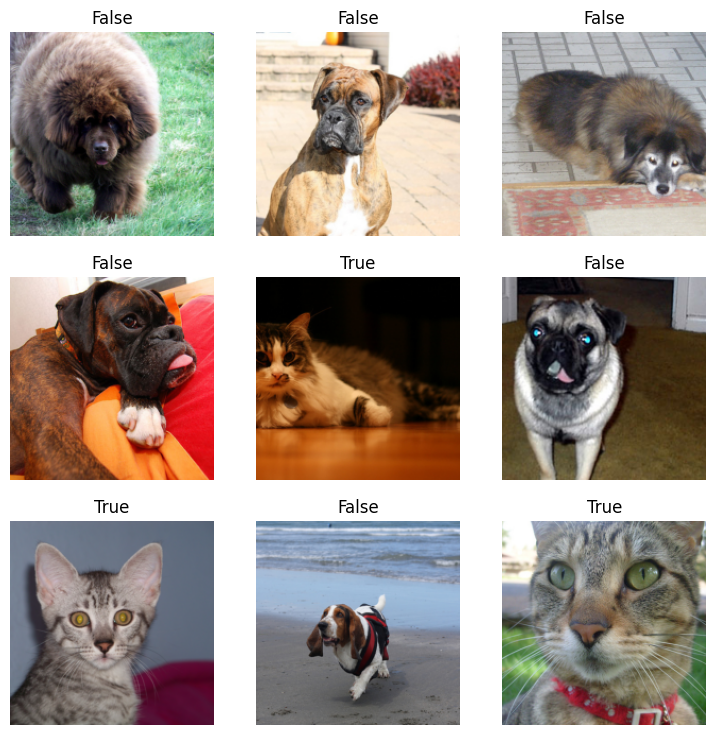

In [ ]:
def is_cat(x): return x[0].isupper()

dls = ImageDataLoaders.from_name_func('.',
  get_image_files(path), valid_pct=0.2, seed=42,
  # 此處不能用到 lambda 否則最後 export 時會無法 pickle
  # 錯誤訊息: PicklingError: Can't pickle <function <lambda> at 0x7d4f3435cb80>: attribute lookup <lambda> on __main__ failed
  # ex. label_func=lambda x: x[0].isupper(),
  label_func=is_cat,
  item_tfms=Resize(192))
dls.show_batch()

要訓練多少個 epoch？
- 當 error_rate 滿足你的需求
- 直到錯誤率開始變得更糟 (overfitting)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

## 儲存

`export`：利用 pickle 儲存 architecture、parameter，也包含 DataLoaders 的設定 (會使用 validation
set DataLoader 來進行推理)

pickle：序列化 python object，以便於在另一個 python script 中重建 object

可 pickle 的 object type：
- None, Boolean (True、False)
- int, float, complex number
- string (normal、Unicode), bytes, byte array
- list, set, tuple, dictionary (只包含 picklable object)
- (用戶定義的、內置的) function，需在 module 的 top level 定義
  - 透過 function 自身的 fully qualified 名稱來進行 pickle，而不是透過值 pickle
  - 這是為何 lambda function 沒辦法被 pickle，因為所有的 lambda function 的名稱都一樣叫做 \<lambda\>
- class instance，需在 module 的 top level 定義 class
  - 實際上不會儲存任何的 class 程式碼、class 屬性，存的是 instance 的屬性

In [ ]:
learn.export('model.pkl') # 存為 pickle file

# dog vs. cat classifier - inference

In [ ]:
#|default_exp app

## 安裝

In [ ]:
!pip install -Uqq fastai gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.7 MB/s eta 0:

## 載入模型來推理

In [ ]:
#|export
from fastai.vision.all import *
import gradio as gr

注意此專案需要三張範例圖片 `dog.jpg`、`cat.jpg`、`dunno.jpg`

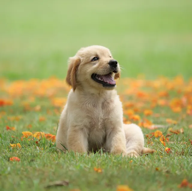

In [ ]:
im = PILImage.create('dog.jpg')
im.thumbnail((192, 192))
im

In [ ]:
#|export
def is_cat(x): return x[0].isupper() # 在 labeling 中使用的任何外部 function 也需要包含在此處，雖然有保存模型的內容，但沒有該 function 的程式碼

learn = load_learner('model.pkl')

In [ ]:
learn.predict(im)

('False', tensor(0), tensor([1.0000e+00, 2.7516e-07]))

In [ ]:
#|export
categories = ('Dog', 'Cat') # 此處自訂 Gradio 界面想顯示的類別名稱 (原本的 label (learn.dls.vocab) 是 Boolean, 沒有可讀性)
def classify_image(img):
    pred,pred_idx,probs = learn.predict(img)
    return dict(zip(categories, map(float, probs))) # Gradio 不能處理 Pytorch Tensor、Numpy Array, 所以轉為 dictionary (category->prob)

In [ ]:
classify_image(im)

{'Dog': 0.9999997615814209, 'Cat': 2.7515861233951e-07}

## Gradio 界面

In [ ]:
#|export
image = gr.components.Image(shape=(192,192))
label = gr.components.Label()
examples = ['dog.jpg', 'cat.jpg', 'dunno.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


## 導出 .py

`nbdev.export.nb_export`：提供將 jupyter 導出為 .py

cell 頂部可以寫指令
- `#|export`：有此指令的 cell，才會被導出
- `#|default_exp app`：預設導出的檔案名稱

由於在 colab 中我無法確定 notebook 所在路徑，這邊先手動下載 .ipynb，再把 .ipynb 上傳到虛擬機內，再執行導出的命令

In [ ]:
!pip install -Uqq nbdev

import nbdev

nbdev.export.nb_export('02.ipynb', 'app') # 導出 app/app.py

# 本機安裝環境

mamba：package manager，高效能，與 conda 完美兼容

Ubuntu 16.04
```shell
git clone https://github.com/fastai/fastsetup.git
cd fastsetup
./setup-conda.sh
mamba install platformdirs -y
mamba install -c fastchan fastai -y
mamba install -c fastchan nbdev -y
mamba install -c conda-forge notebook -y
```